In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Importing useful libraries
import numpy as np
import os
import copy
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1 Breast Cancer Wisconsin Dataset

## ***WHAT DOES THE RMSE MEANS IN ABSOLUTE TERMS***

- can the model be used in the real world 
- error margin 
    - e.g. a 10% error margin is not good enough to be implemented in a real world
- what can we do to improve the rmse
    - get more data
    - get more weighted data 
    - contexttualize your answer

- learn what the hyperparameter does
    - give an explanation
    - why are we choosing this range for the grid search 
    - how can you get a higher 
    - is this practical? 
        - consider training and computing time based on your hyperparameter selection 
        
- Discuss, make assumptions and see what is plausible 

WHEN THE SHEET SAYS MANUALLY TUNE THE STUFF:
- choose a range of values (explain why)
- plot the results (error?)

## 1.1 Loading the dataset 

In [2]:
from sklearn.datasets import load_breast_cancer

# Load as a sklearn bunch object
breast_cancer = load_breast_cancer()

# Convert to dataframe
cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
cancer['target'] = pd.Series(breast_cancer.target)

In [3]:
cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 1.2 Investigating the Data

### 1.2.1 Feature Selection

***RUN THE CLASSIFIER BEFORE DROPPING FEATURES***

- significant increase in accuracy
- speed penalty
- trade off in computing resources 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

cancer_copy = copy.deepcopy(cancer)
cancer_copy.drop('target', axis=1, inplace=True)

When investigating if some features can be dropped due to a linear relationship, it is common to plot a scatter matrix that plots each feature against each other feature. However, in this dataset which contains 30 features, that would require 30^2 (900) plots. This is an unrealistic number to plot, display and sort through.

Therefore, the heatmap function from the seaborn library was used to plot a correlation matrix. The correlation value between a pair of features measures the degree of the linear relationship that they have. If the two features have a high correlation score (approaching 1) it means that they are linear and measure the same variable.

We will loop through this correlation matrix and drop any feature that has a correlation with 0.9 or more. 

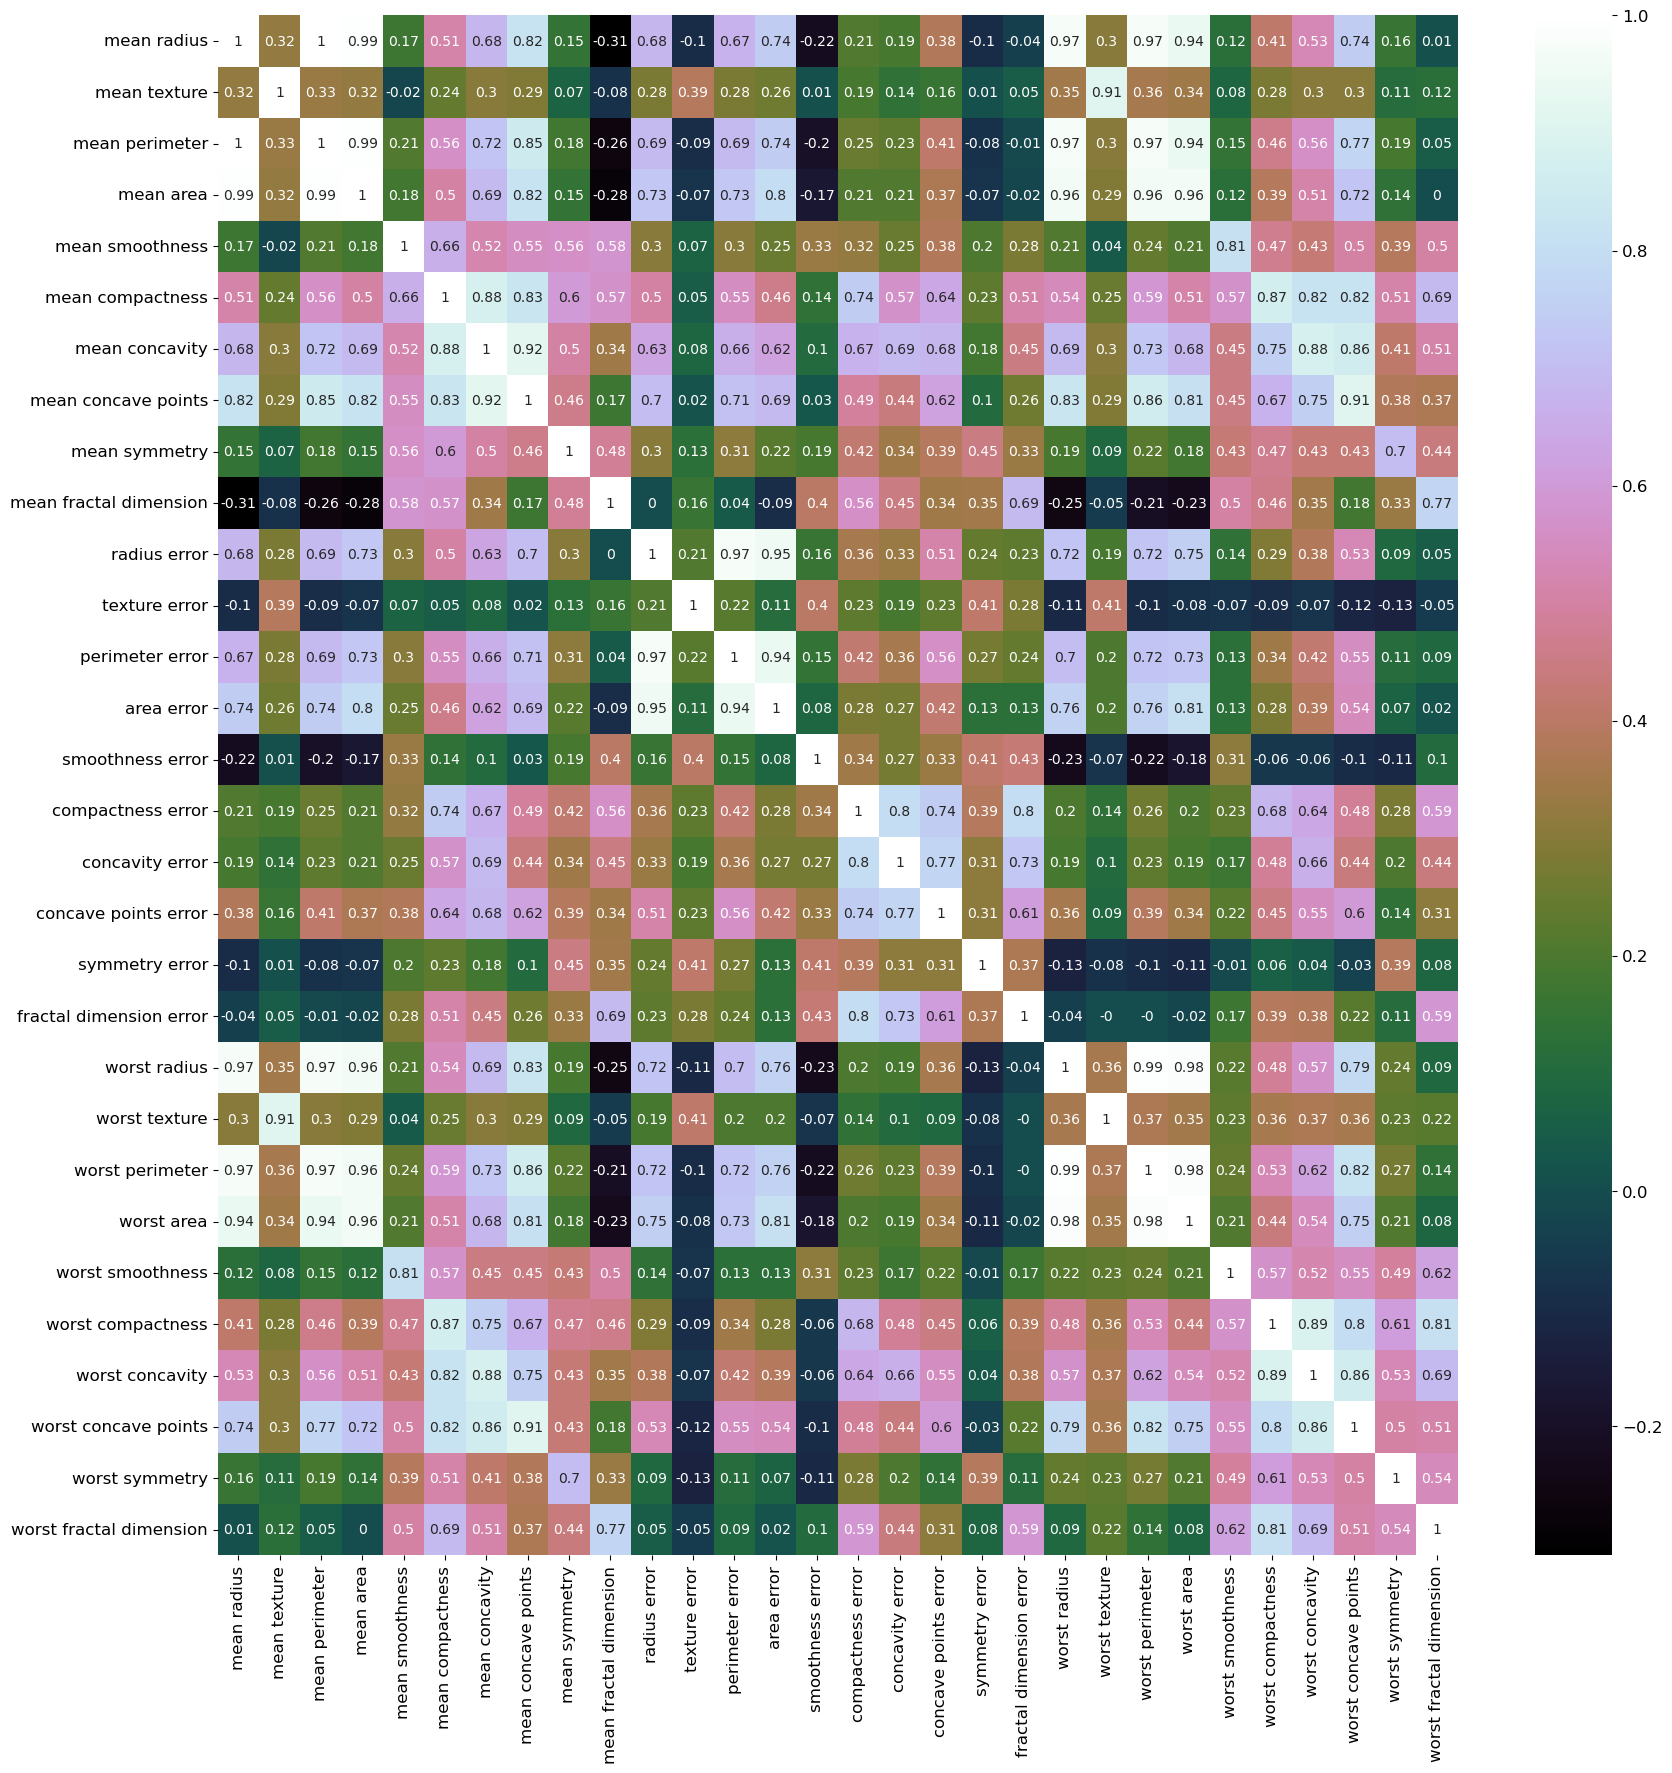

In [5]:
correlation_cancer = cancer_copy.corr().round(2)

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_cancer, cmap='cubehelix', annot=True)
plt.show()

In [6]:
cancer_copy = copy.deepcopy(cancer)
cancer_copy.drop('target', axis=1, inplace=True)

# create a set to hold the names of the features to drop
to_drop = set()

# iterate over the columns in the correlation matrix
for col in range(len(correlation_cancer.columns)):
    # iterate over the rows in the correlation matrix
    for row in range(col):
        # check if the absolute correlation value is greater than 0.9
        if abs(correlation_cancer.iloc[row, col]) > 0.9:
            # if so, add the name of the feature to the set of features to drop
            colname = correlation_cancer.columns[col]
            to_drop.add(colname)

# drop the features with high correlation
cancer_copy = cancer_copy.drop(to_drop, axis=1)

In [7]:
cancer_copy.head()

,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean symmetry,mean fractal dimension,radius error,texture error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst smoothness,worst compactness,worst concavity,worst symmetry,worst fractal dimension
0,17.99,10.38,0.11840,0.27760,0.3001,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.4601,0.11890
1,20.57,17.77,0.08474,0.07864,0.0869,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.2750,0.08902
2,19.69,21.25,0.10960,0.15990,0.1974,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.3613,0.08758
3,11.42,20.38,0.14250,0.28390,0.2414,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.6638,0.17300
4,20.29,14.34,0.10030,0.13280,0.1980,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.2364,0.07678


The following plot shows a scatter matrix for some of the variables that were eliminated. They have a high correlation value as per the correlation matrix above. Plotting them against each other on a scatter matrix demonstrates that variables that have a high correlation do indeed have a linear relationship. 

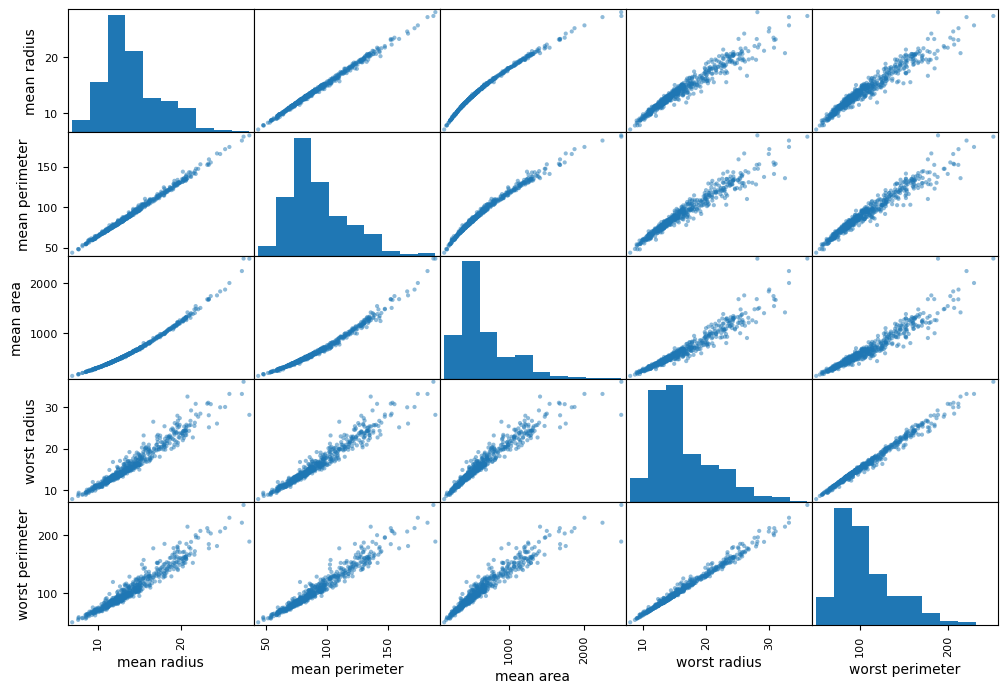

In [8]:
from pandas.plotting import scatter_matrix

attributes = ['mean radius', 'mean perimeter', 'mean area', 'worst radius', 'worst perimeter']

scatter_matrix(cancer[attributes], figsize=(12,8))
plt.show()

The following plot is a visualization of the first five features that remain in our dataset. The points from each class have been plotted in a different colour. 

It can be seen from these point plots that the points from the two classes are well seperated. This indicates that we have done a good job in dropping the features in the previous step and the following classification task will be relatively easy.

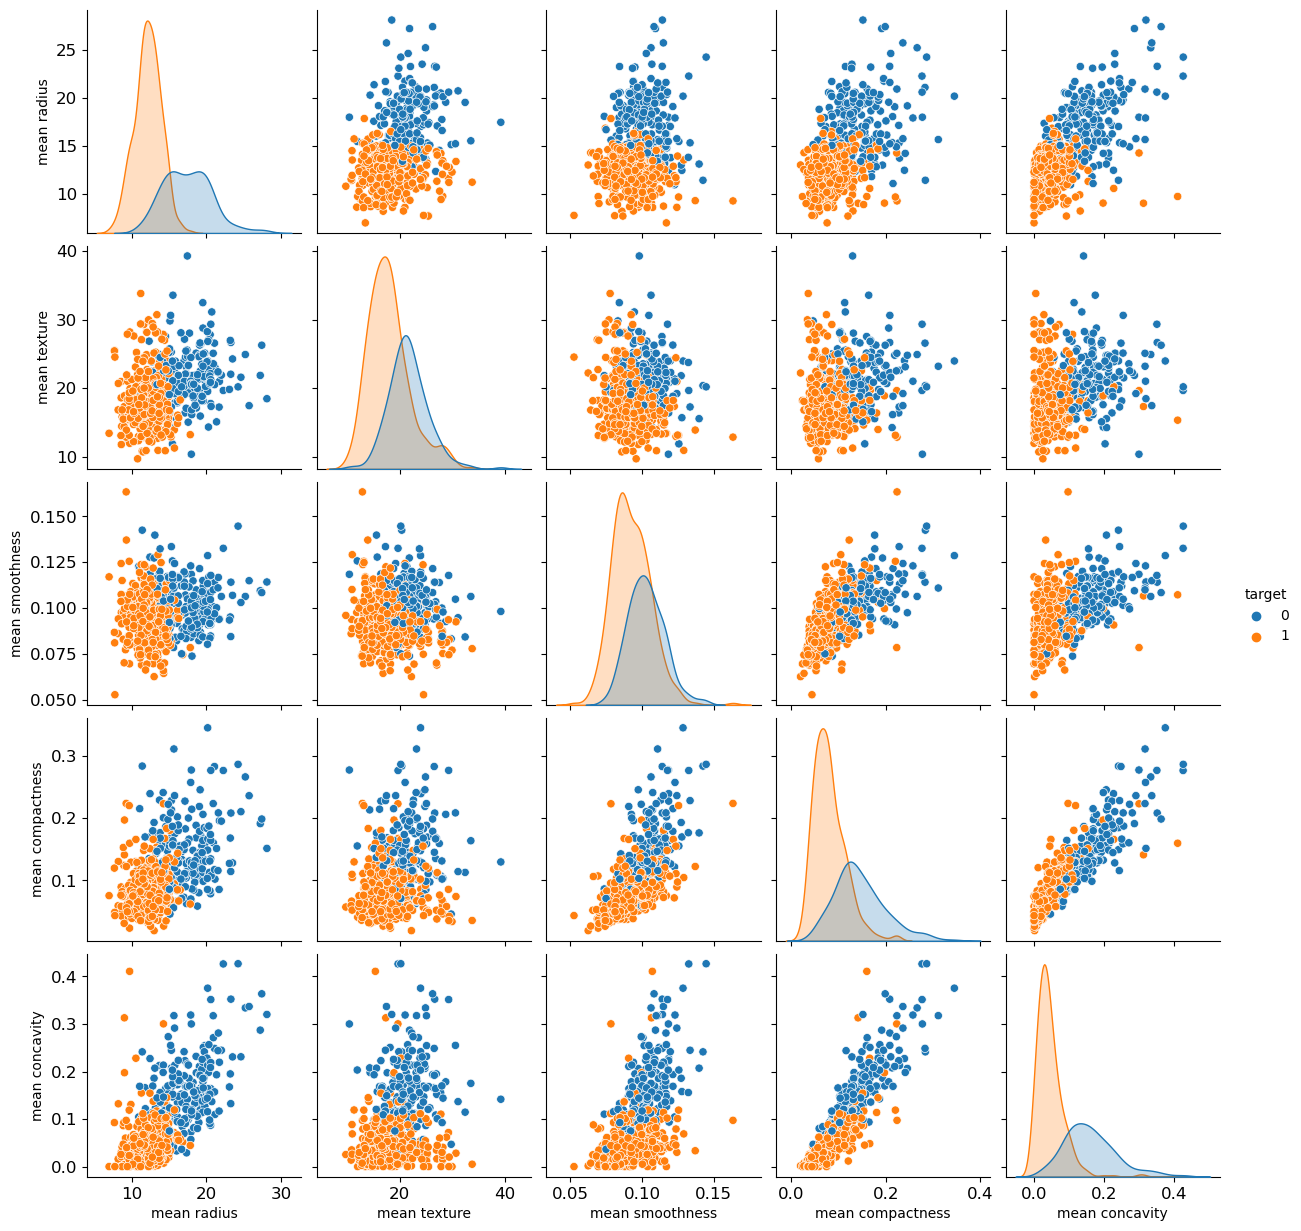

In [9]:
# select the first 5 features to plot
first_five = cancer_copy.columns[:5]

# Plot the relationship between features and target
sns.pairplot(cancer, vars=first_five, hue='target')
plt.show()

### 1.3.1 Preparing the training and test sets

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Splitting the dataset into a training set (85%) and a testing set (15%) randomstate=123
cancer_train_X, cancer_test_X, cancer_train_y, cancer_test_y = train_test_split(cancer_copy, cancer['target'], test_size=0.15, random_state=123)

# Creating a new instance of the standard scaler
scaler_func = StandardScaler()

cancer_train_X = scaler_func.fit_transform(cancer_train_X)
cancer_test_X = scaler_func.transform(cancer_test_X)

## 1.3 Decision Trees

In [11]:
# defining a set to store the accuracies of different classifiers
train_accuracy_set = list()
test_accuracy_set = list()

### 1.3.1 Default Hyperparameters

The following cells will involve training a decision tree classifier on the selected features using the default hyperparameters.

It can be seen from the accuracy scores of 1 on the training set and 0.89 on the test set that the classifier has an overfitting issue. It can be seen from the perfect accuracy score on the training set that the model has fit very closely to the training data. However, given the fact that the accuracy drops to 0.89 on the test set suggests that the model is not performing as well on new, unseen data. This is a sign of overfitting. 

The classification report also gives insight into the performance of the classifier by providing the precision and recall scores. The model's precision dropped from 1 to 0.89 and recall dropped from 1 to 0.89 when moving from training data to test data. This suggests that the model is making more false positive and false negative predictions when presented with new data. This is another sign of overfitting

In [12]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

tree_default = DecisionTreeClassifier()
tree_default.fit(cancer_train_X, cancer_train_y)

y_pred_train_default = tree_default.predict(cancer_train_X)
accuracy_train_default = accuracy_score(cancer_train_y, y_pred_train_default)
train_accuracy_set.append(accuracy_train_default)
report_train_default = classification_report(cancer_train_y, y_pred_train_default)

y_pred_test_default = tree_default.predict(cancer_test_X)
accuracy_test_default = accuracy_score(cancer_test_y, y_pred_test_default)
test_accuracy_set.append(accuracy_test_default)
report_test_default = classification_report(cancer_test_y, y_pred_test_default)

print('Tree depth:', tree_default.get_depth())
print('The accuracy on the training set:', accuracy_train_default)
print('\n', report_train_default)
print('The accuracy on the testing set:', accuracy_test_default)
print('\n', report_test_default)

Tree depth: 7
The accuracy on the training set: 1.0

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       1.00      1.00      1.00       307

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483

The accuracy on the testing set: 0.9069767441860465

               precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.92      0.92      0.92        50

    accuracy                           0.91        86
   macro avg       0.90      0.90      0.90        86
weighted avg       0.91      0.91      0.91        86



***IDK what to talk about here tbh***

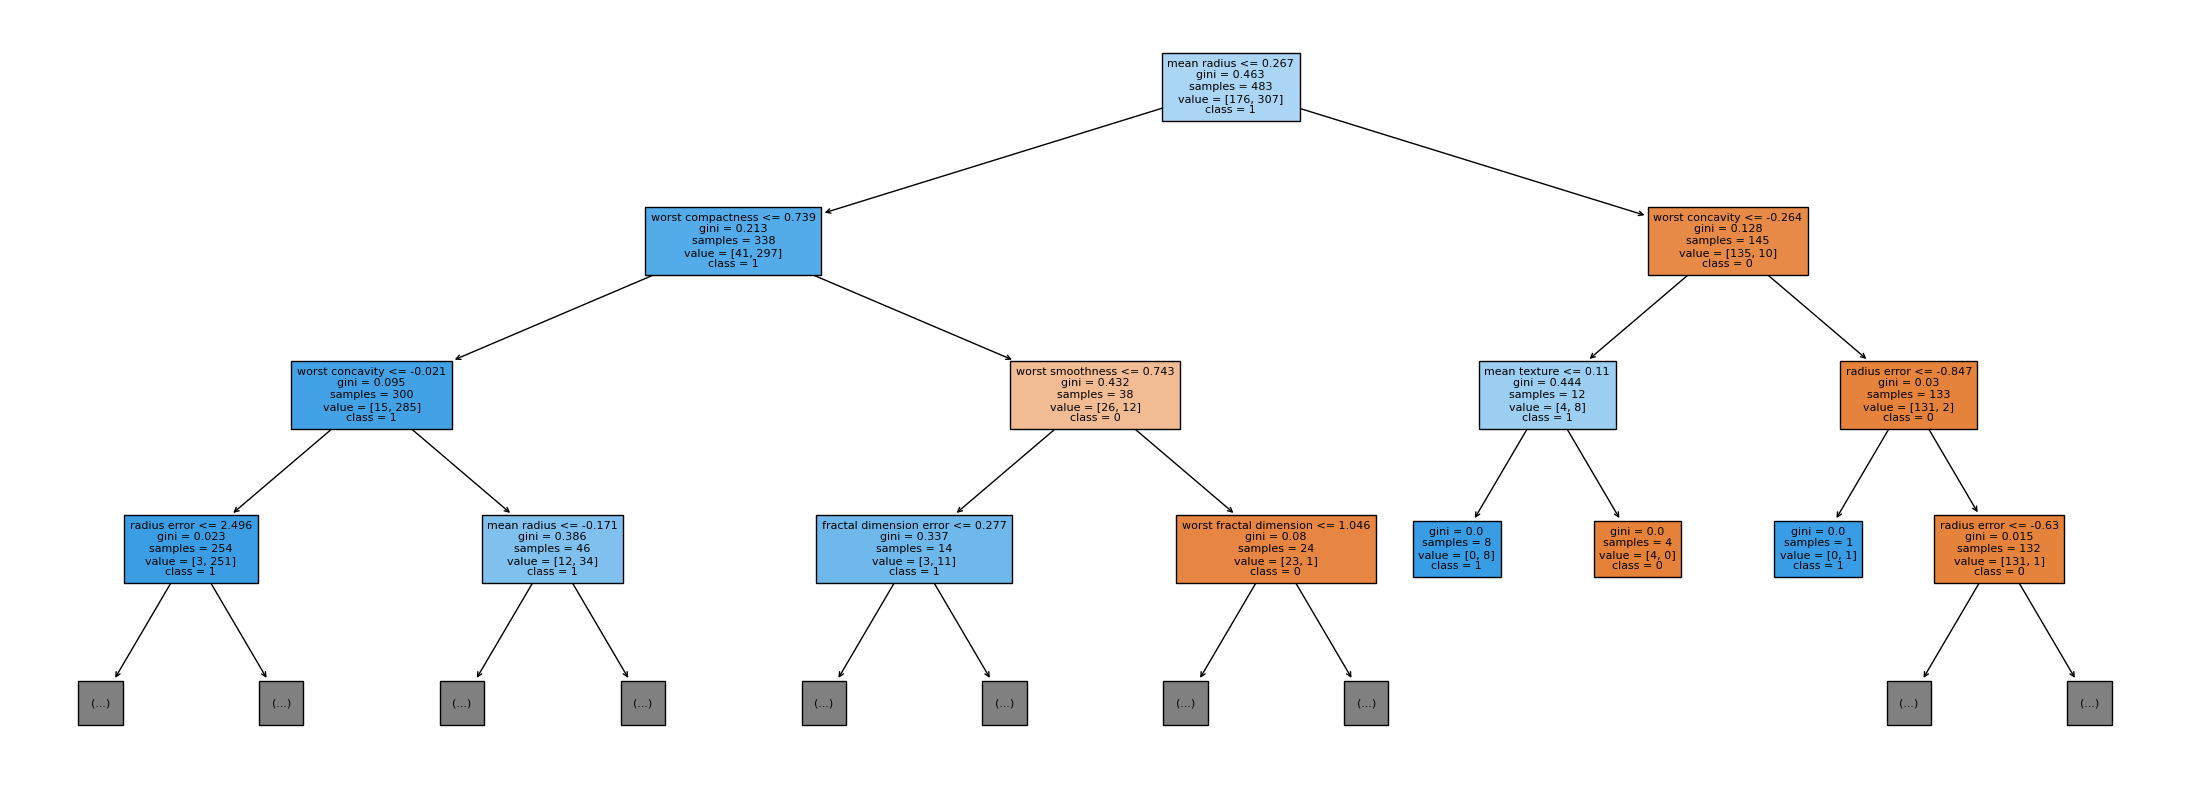

In [13]:
# Display the decision tree built from the training process (limited to max_depth=3)
plt.figure(figsize=(28, 10))
plot_tree(tree_default, max_depth=3, filled=True, feature_names=cancer_copy.columns, class_names=['0','1'],fontsize=8)
plt.show()

### 1.3.2 Restricting Depth to 3

The following cells will involve training a decision tree classifier on the selected features with max_depth=3 and the other hyperparameters set to their default values.

By setting max_depth=3, the classifier's performance has improved on both the training and testing sets. The accuracy on the training set is 0.95, which is lower than the previous score of 1. While this is a reduction in the accuracy as compared to before, this is a step in the positive direction. This suggests that the model is no longer overfitting as much to the training data.

On the test set, the accuracy has decreased slightly to 0.88, but the precision and recall scores have also improved to 0.89 and 0.87, respectively. This suggests that the model is performing well on new, unseen data and is able to generalize well beyond the training set.

In [14]:
tree_depth = DecisionTreeClassifier(max_depth=3)
tree_depth.fit(cancer_train_X, cancer_train_y)

y_pred_train_depth = tree_depth.predict(cancer_train_X)
accuracy_train_depth = accuracy_score(cancer_train_y, y_pred_train_depth)
train_accuracy_set.append(accuracy_train_depth)
report_train_depth = classification_report(cancer_train_y, y_pred_train_depth)

y_pred_test_depth = tree_depth.predict(cancer_test_X)
accuracy_test_depth = accuracy_score(cancer_test_y, y_pred_test_depth)
test_accuracy_set.append(accuracy_test_depth)
report_test_depth = classification_report(cancer_test_y, y_pred_test_depth)

print('Tree depth:', tree_depth.get_depth())
print('The accuracy on the training set:', accuracy_train_depth)
print('\n', report_train_depth)
print('The accuracy on the testing set:', accuracy_test_depth)
print('\n', report_test_depth)

Tree depth: 3
The accuracy on the training set: 0.9585921325051759

               precision    recall  f1-score   support

           0       0.99      0.90      0.94       176
           1       0.94      0.99      0.97       307

    accuracy                           0.96       483
   macro avg       0.97      0.95      0.95       483
weighted avg       0.96      0.96      0.96       483

The accuracy on the testing set: 0.8837209302325582

               precision    recall  f1-score   support

           0       0.91      0.81      0.85        36
           1       0.87      0.94      0.90        50

    accuracy                           0.88        86
   macro avg       0.89      0.87      0.88        86
weighted avg       0.89      0.88      0.88        86



### 1.3.3 Setting Min Samples Split  to 5

The following cells will involve training a decision tree classifier on the selected features with min_samples_split=5 and the other hyperparameters set to their default values.

The classifier's performance has improved significantly on both the training and testing sets. The accuracy on the training set is now 0.99, which suggests that the model is performing very well on the training data. The precision and recall scores on the training set have also improved to 1, which indicates that the model is perfectly identifying the positive cases in the training set. While this may look similar to the scores from section 1.3.1 where it was argued that accuracy, precision and recalls so close to being perfect on the training data are a sign of overfitting, further examination of the scores on the testing data reveals further insights. 

On the test set, the accuracy has improved to 0.90, which suggests that the model is able to generalize well beyond the training set. The precision and recall scores on the test set are both 0.89, which is also very good and suggests that the model is able to correctly identify positive cases with a low false positive rate and a low false negative rate.

The performance of this classifier suggests that tuning the min_samples_split hyperparameter is a good way to improve model performance.

In [15]:
tree_split = DecisionTreeClassifier(min_samples_split=5)
tree_split.fit(cancer_train_X, cancer_train_y)

y_pred_train_split = tree_split.predict(cancer_train_X)
accuracy_train_split = accuracy_score(cancer_train_y, y_pred_train_split)
train_accuracy_set.append(accuracy_train_split)
report_train_split = classification_report(cancer_train_y, y_pred_train_split)

y_pred_test_split = tree_split.predict(cancer_test_X)
accuracy_test_split = accuracy_score(cancer_test_y, y_pred_test_split)
test_accuracy_set.append(accuracy_test_split)
report_test_split = classification_report(cancer_test_y, y_pred_test_split)

print('Tree split:', tree_split.get_depth())
print('The accuracy on the training set:', accuracy_train_split)
print('\n', report_train_split)
print('The accuracy on the testing set:', accuracy_test_split)
print('\n', report_test_split)

Tree split: 7
The accuracy on the training set: 0.9917184265010351

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       176
           1       1.00      0.99      0.99       307

    accuracy                           0.99       483
   macro avg       0.99      0.99      0.99       483
weighted avg       0.99      0.99      0.99       483

The accuracy on the testing set: 0.9069767441860465

               precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.92      0.92      0.92        50

    accuracy                           0.91        86
   macro avg       0.90      0.90      0.90        86
weighted avg       0.91      0.91      0.91        86



### 1.3.4 Setting Min Samples Leaf to 5

The following cells will involve training a decision tree classifier on the selected features with min_samples_leaf=5 and the other hyperparameters set to their default values.

On the test set, the accuracy has not improved significantly and remains at 0.88. The precision and recall scores on the test set are also 0.88, indicating that the model is performing consistently on both the training and testing sets.

Overall, the similar precision and recall scores on both the training and testing sets suggest that the model is not overfitting and is able to generalize well to new, unseen data. However, the relatively low accuracy on the testing set suggests that there is still room for improvement

In [16]:
tree_leaf = DecisionTreeClassifier(min_samples_leaf=5)
tree_leaf.fit(cancer_train_X, cancer_train_y)

y_pred_train_leaf = tree_leaf.predict(cancer_train_X)
accuracy_train_leaf = accuracy_score(cancer_train_y, y_pred_train_leaf)
train_accuracy_set.append(accuracy_train_leaf)
report_train_leaf = classification_report(cancer_train_y, y_pred_train_leaf)

y_pred_test_leaf = tree_leaf.predict(cancer_test_X)
accuracy_test_leaf = accuracy_score(cancer_test_y, y_pred_test_leaf)
test_accuracy_set.append(accuracy_test_leaf)
report_test_leaf = classification_report(cancer_test_y, y_pred_test_leaf)

print('The accuracy on the training set:', accuracy_train_leaf)
print('\n', report_train_leaf)
print('The accuracy on the testing set:', accuracy_test_leaf)
print('\n', report_test_leaf)

The accuracy on the training set: 0.9772256728778468

               precision    recall  f1-score   support

           0       0.95      0.99      0.97       176
           1       1.00      0.97      0.98       307

    accuracy                           0.98       483
   macro avg       0.97      0.98      0.98       483
weighted avg       0.98      0.98      0.98       483

The accuracy on the testing set: 0.8837209302325582

               precision    recall  f1-score   support

           0       0.84      0.89      0.86        36
           1       0.92      0.88      0.90        50

    accuracy                           0.88        86
   macro avg       0.88      0.88      0.88        86
weighted avg       0.89      0.88      0.88        86



## 1.4 Using Cross-Validation to find best hyperparameters

In [17]:
from sklearn.model_selection import GridSearchCV

# Create a new Decision Tree Classifier
tree = DecisionTreeClassifier()

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=3, scoring='accuracy')
# Fit the grid search object to the training data
grid_search.fit(cancer_train_X, cancer_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best cross-validation score: 0.9337474120082816


## 1.5 Training Model on best Hyperparameters

The following cells will involve training a decision tree classifier on the selected features with the best hyperparameters as determined through a grid search with 3-fold cross validation. The best hyperparameters are:

- max_depth=5
- min_samples_leaf=1
- min_samples_split=5

On the test set, the accuracy has improved significantly at 0.91. The precision and recall scores on the test set are also 0.91 and 0.90 indicating that the model is performing consistently on both the training and testing sets. 

Overall, the high precision and recall scores on both the training and testing sets suggest that the model is not overfitting and is able to generalize well to new, unseen data. 

In [18]:
tree_best = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=5)
tree_best.fit(cancer_train_X, cancer_train_y)

y_pred_train_best = tree_best.predict(cancer_train_X)
accuracy_train_best = accuracy_score(cancer_train_y, y_pred_train_best)
train_accuracy_set.append(accuracy_train_best)
report_train_best = classification_report(cancer_train_y, y_pred_train_best)

y_pred_test_best = tree_best.predict(cancer_test_X)
accuracy_test_best = accuracy_score(cancer_test_y, y_pred_test_best)
test_accuracy_set.append(accuracy_test_best)
report_test_best = classification_report(cancer_test_y, y_pred_test_best)

print('The accuracy on the training set:', accuracy_train_best)
print('\n', report_train_best)
print('The accuracy on the testing set:', accuracy_test_best)
print('\n', report_test_best)

The accuracy on the training set: 0.9813664596273292

               precision    recall  f1-score   support

           0       0.98      0.97      0.97       176
           1       0.98      0.99      0.99       307

    accuracy                           0.98       483
   macro avg       0.98      0.98      0.98       483
weighted avg       0.98      0.98      0.98       483

The accuracy on the testing set: 0.9069767441860465

               precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.92      0.92      0.92        50

    accuracy                           0.91        86
   macro avg       0.90      0.90      0.90        86
weighted avg       0.91      0.91      0.91        86



## 1.6 Comparison

In [19]:
labels_train = ['Default_train', 'Max_Depth_train', 'Min_Samples_Split_train', 'Min_Samples_Leaf_train', 'Best_train']
labels_test = ['Default_test', 'Max_Depth_test', 'Min_Samples_Split_test', 'Min_Samples_Leaf_test', 'Best_test']

def plot_accuracy_graph():
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # create a bar chart for the first set of values and labels
    axs[0].bar(labels_train, train_accuracy_set, color=colors, width=0.9)
    for i, v in enumerate(train_accuracy_set):
        axs[0].text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
    axs[0].set_title('Accuracy Values Training Set')
    axs[0].set_xlabel('Models')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xticks(range(len(labels_train)))
    axs[0].set_xticklabels(labels_train, rotation=45)

    # create a bar chart for the second set of values and labels
    axs[1].bar(labels_test, test_accuracy_set, color=colors, width=0.9)
    for i, v in enumerate(test_accuracy_set):
        axs[1].text(i, v, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
    axs[1].set_title('Accuracy Values Testing Set')
    axs[1].set_xlabel('Models')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xticks(range(len(labels_test)))
    axs[1].set_xticklabels(labels_test, rotation=45)

    plt.tight_layout()  # adjust spacing between subplots
    plt.show()

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(predictions, labels, y):
    # Create the figure and axis objects
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

    # Loop through each axis and plot the corresponding confusion matrix
    for i, ax in enumerate(axs.ravel()):
        if i < len(predictions):
            # Calculate the confusion matrix
            conf_matrix = confusion_matrix(y, predictions[i])

            # Plot the confusion matrix
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
            disp.plot(ax=ax, cmap='Oranges_r', values_format='.0f') # use 'Oranges_r' to reverse the orange colormap
            disp.ax_.set_xlabel('Predicted Label')
            disp.ax_.set_ylabel('True Label')
            disp.ax_.set_title(labels[i])

    # Add some space between the plots and show the figure
    fig.tight_layout()
    fig.delaxes(axs[1][2])
    plt.show()

In [22]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(x, y, labels):
    classifiers = [tree_default, tree_depth, tree_split, tree_leaf, tree_best]
    colors = ['red', 'blue', 'green', 'purple', 'orange']

    # Create the figure and axis objects
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    # Loop through each classifier and plot its precision-recall curve on a separate plot
    for i, clf in enumerate(classifiers):
        # Calculate the precision-recall curve
        y_pred_proba = clf.predict_proba(x)[:, 1]
        precision, recall, _ = precision_recall_curve(y, y_pred_proba)

        # Determine the subplot indices for this curve
        row = i // 2
        col = i % 2

        # Plot the precision-recall curve on the subplot
        ax = axs[col, row]
        ax.plot(recall, precision, color=colors[i])
        ax.set_title(labels[i])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')

    # Add some space between the plots and show the figure
    fig.tight_layout()
    fig.delaxes(axs[1][2])
    plt.show()

### 1.6.1 Comparing Accuracy for Different Classifiers

The following plot provides a visual representation of what was discussed in sections 1.3 to 1.5. The classifier trained using the best hyperparameters provides the best generalization capability among the five classifiers tested. While it managed to score well on the training set, it also had the best performance on the testing set. This demonstrates that the high training accuracy did not come at the cost of overfitting

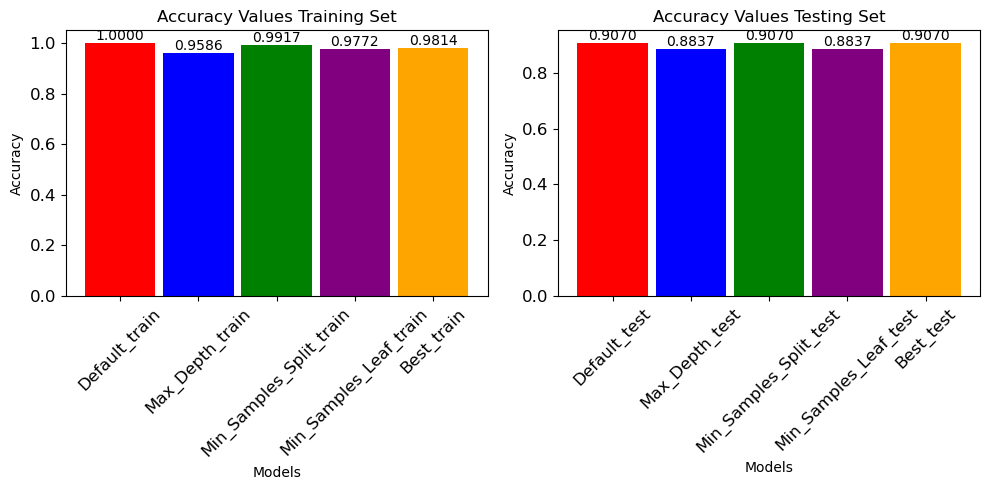

In [23]:
plot_accuracy_graph()

### 1.6.2 Confusion Matrix

When deciding on the precision-recall tradeoff for a classifier, it is important to examine the use case for the classifier and the consequences of incorrect predictions. In this case, we are operating a classifier that is used to screen for malignant tumors and would want a classifier with maximum recall even at the cost of precision.

A false negative (cancer case being classified as negative) is significantly more serious than a false positive (non-cancer case being classified as positive) as a false negative report could result in death due to delayed treatment. On the other hand, a false positive report could be rectified after further tests are conducted at no cost to the patient's health. 

Therefore, it is more important to minimize false negatives, which can be achieved by maximizing recall, even if it means accepting a higher number of false positives and lower precision.

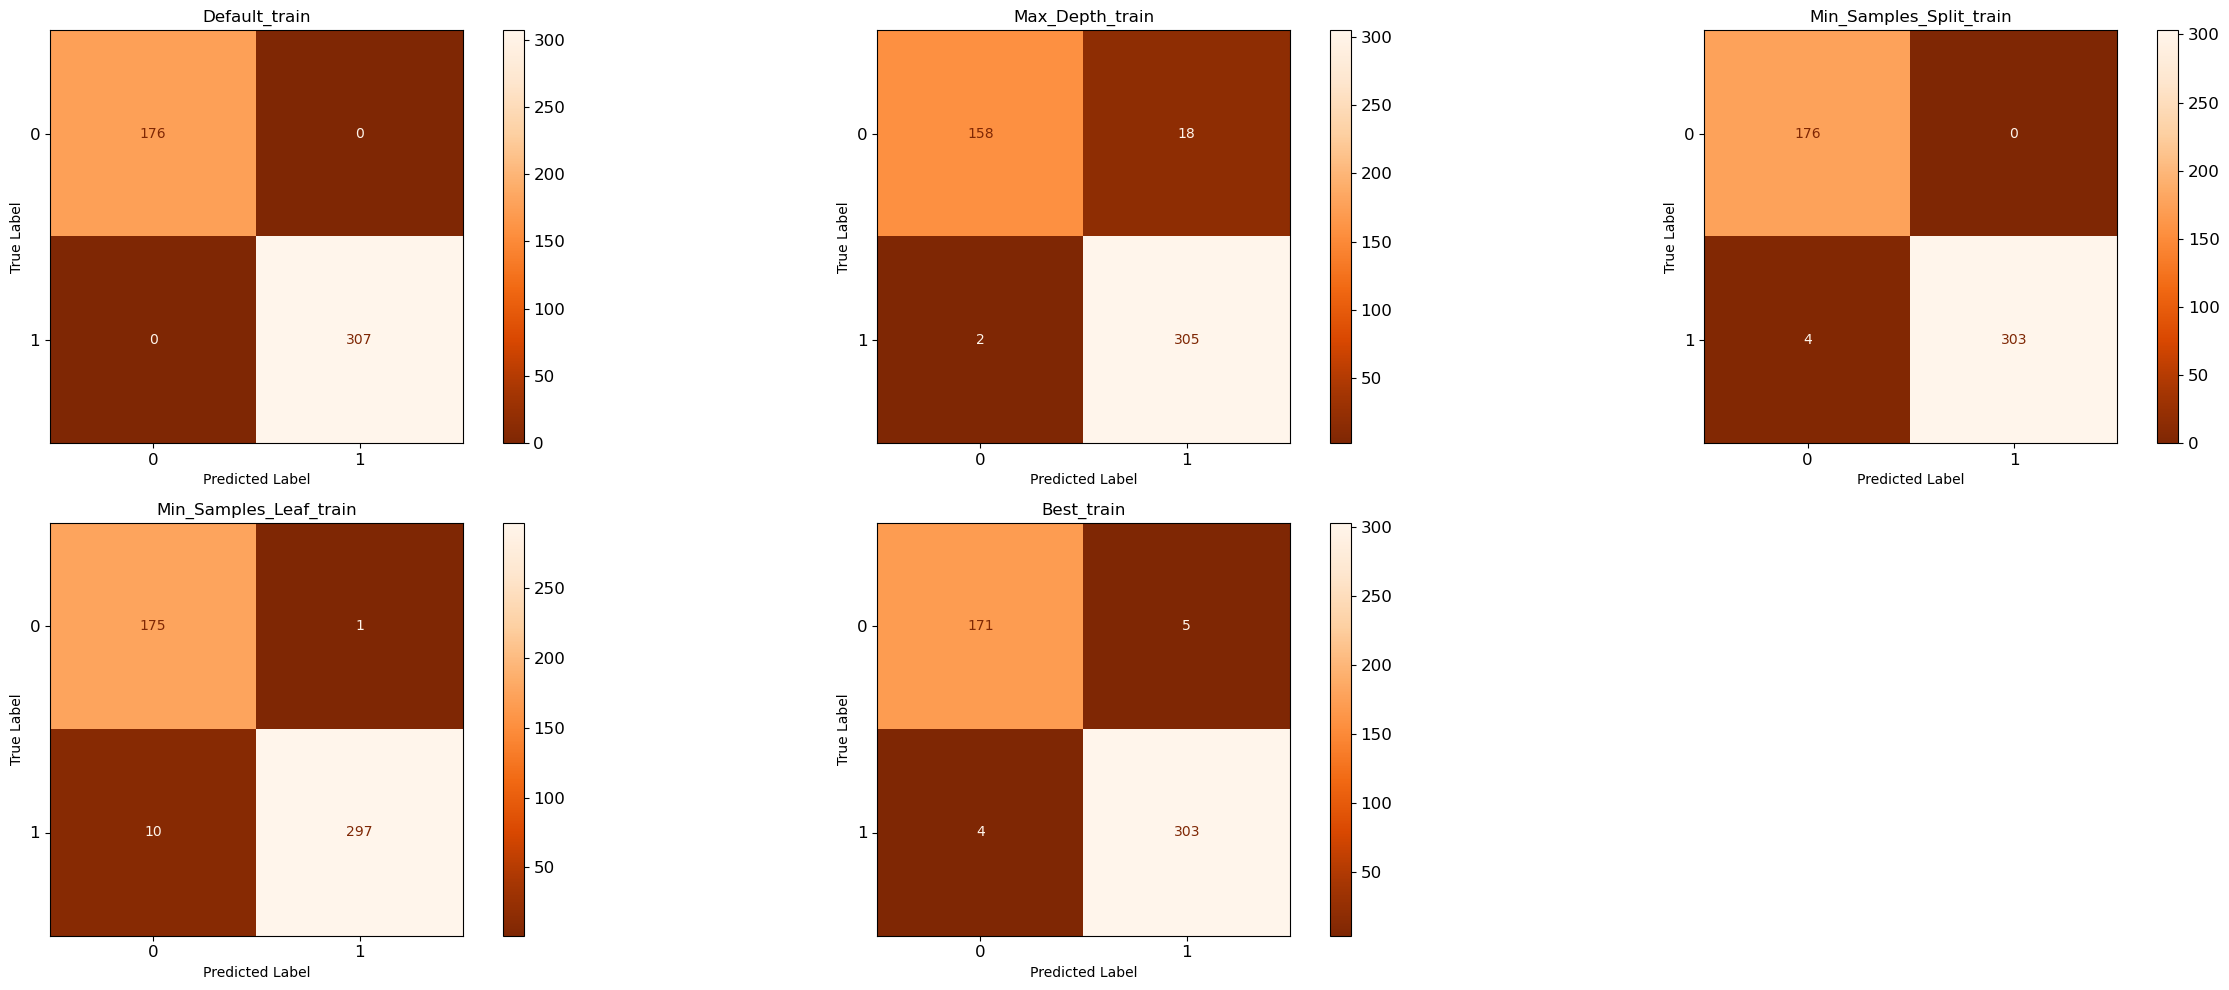

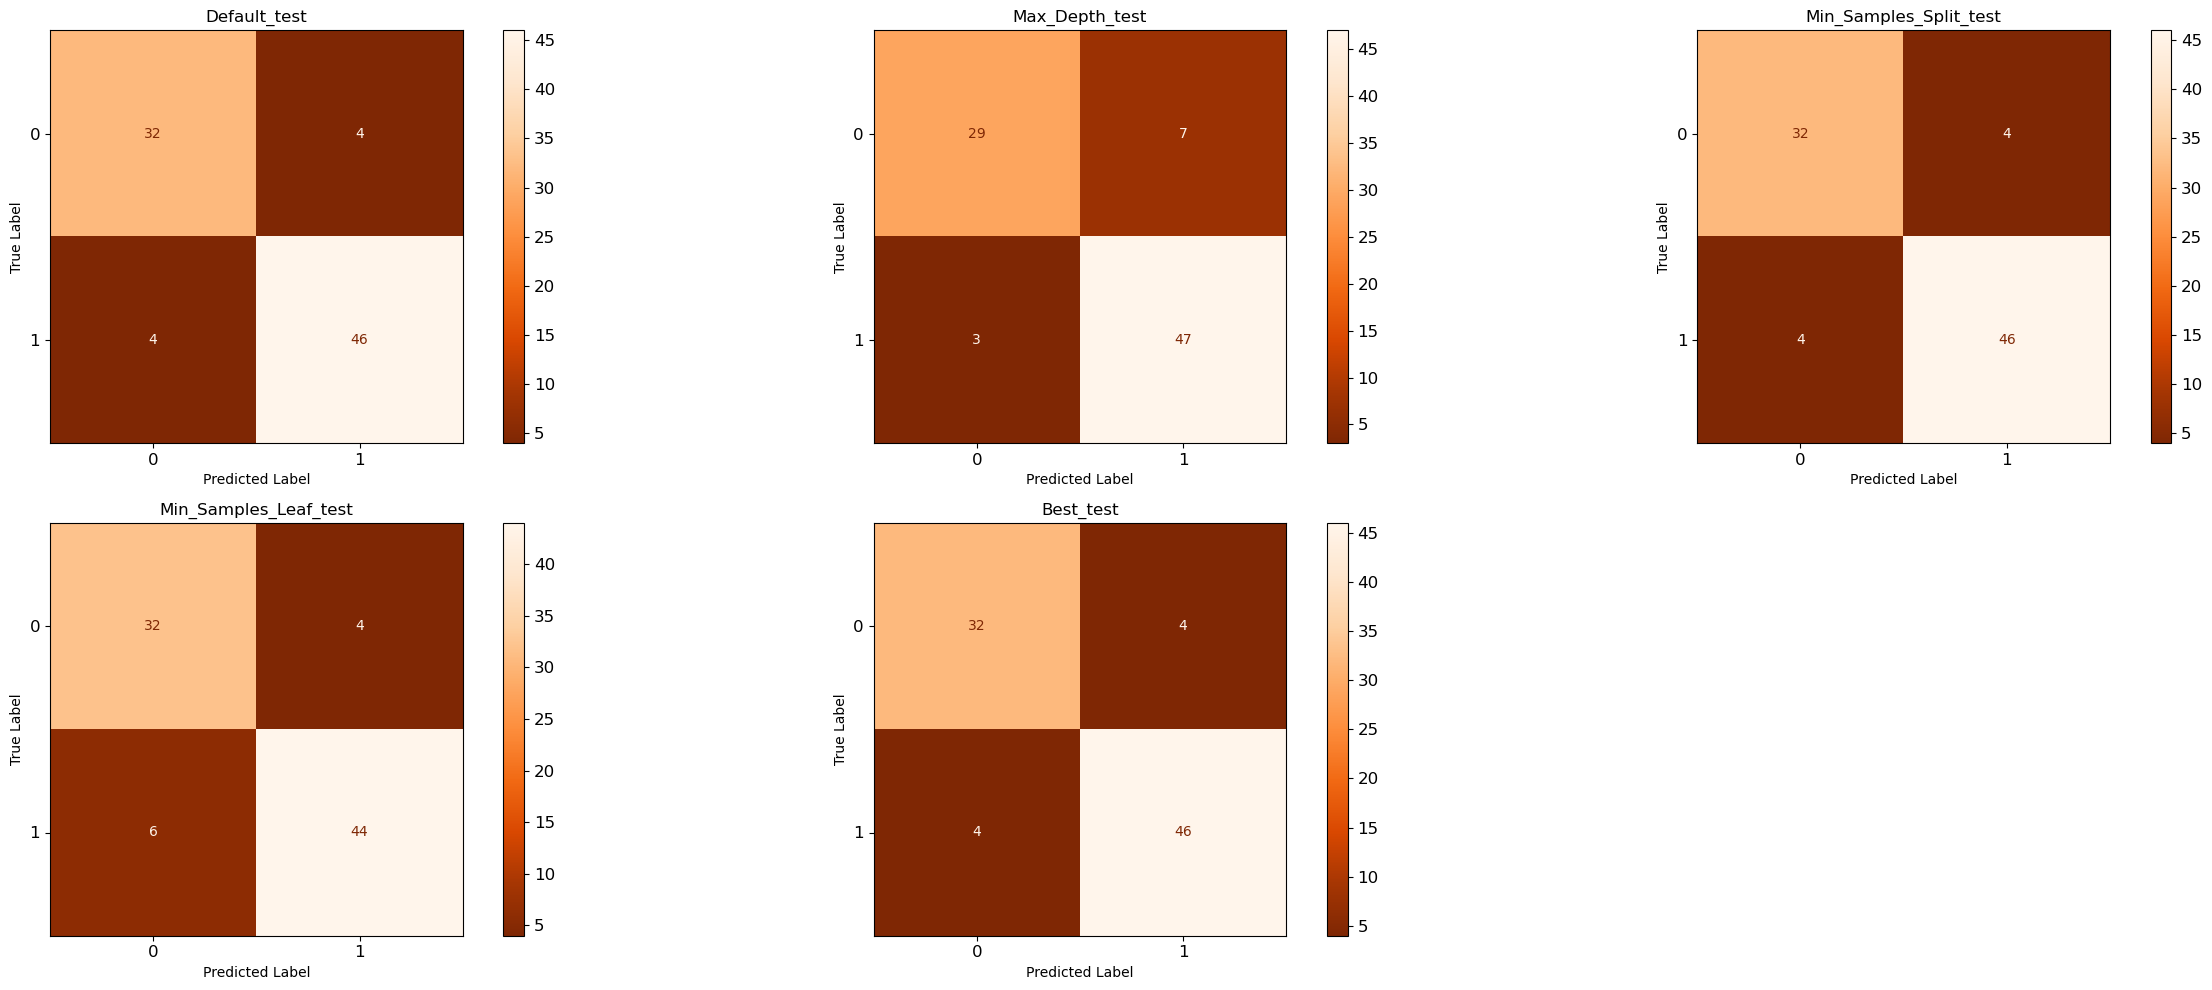

In [24]:
# Define your predictions
predictions_train = [y_pred_train_default, y_pred_train_depth, y_pred_train_split, y_pred_train_leaf, y_pred_train_best]

predictions_test = [y_pred_test_default, y_pred_test_depth, y_pred_test_split, y_pred_test_leaf, y_pred_test_best]

plot_confusion_matrix(predictions_train, labels_train, cancer_train_y)
plot_confusion_matrix(predictions_test, labels_test, cancer_test_y)

***These precision vs recall curves are jank af***

The best regressor is weird - it goes down sharply (as expected) then goes back up as recall increases 

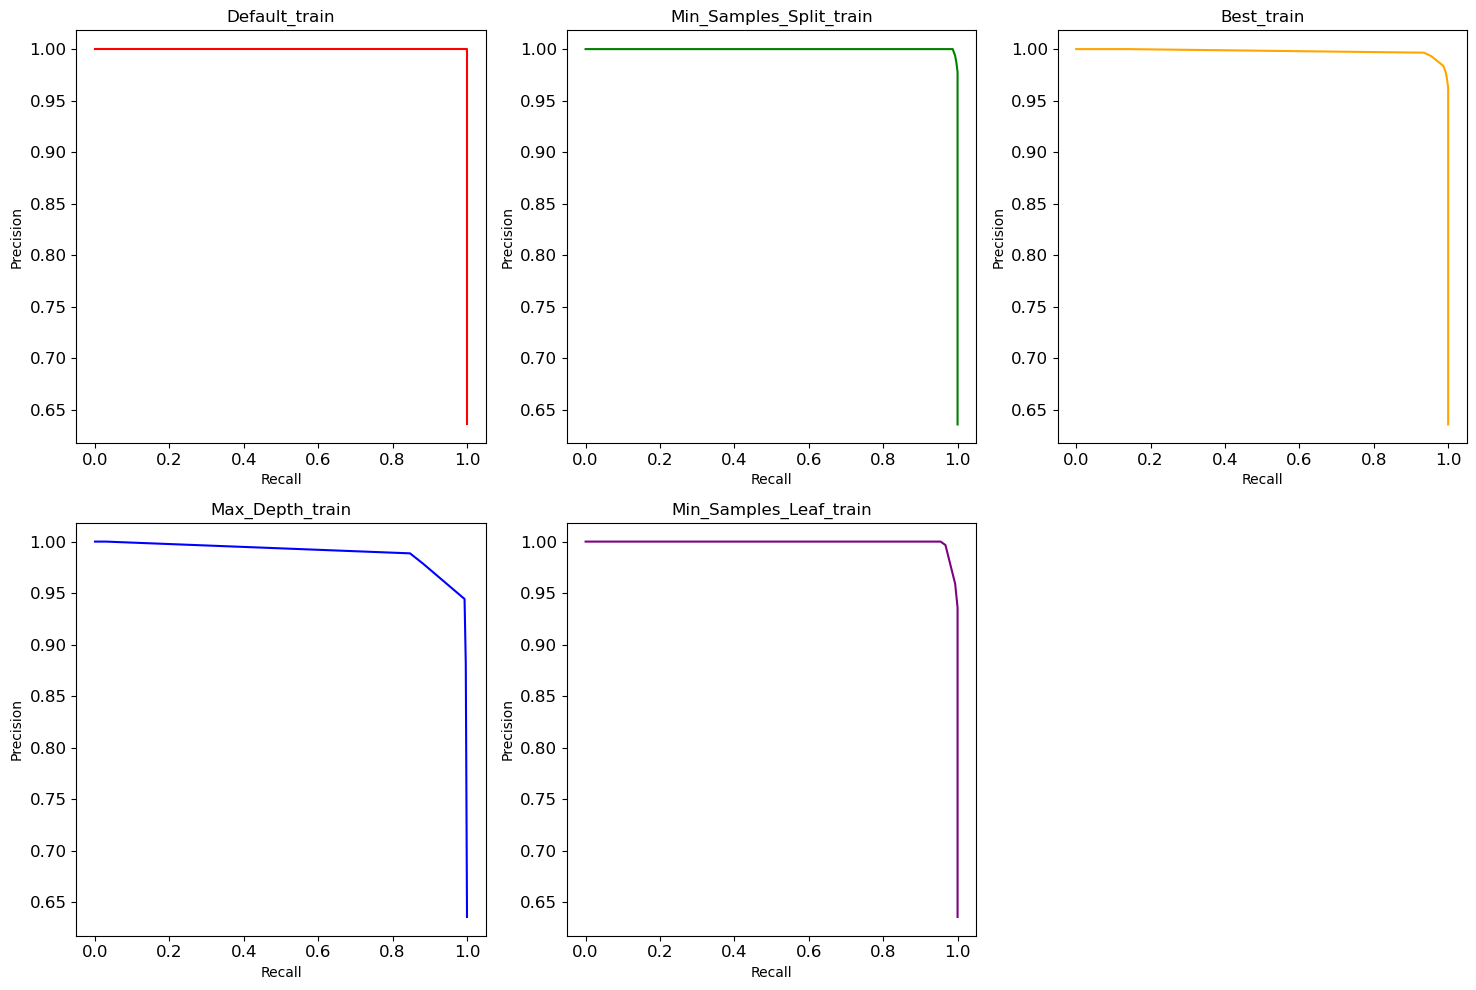

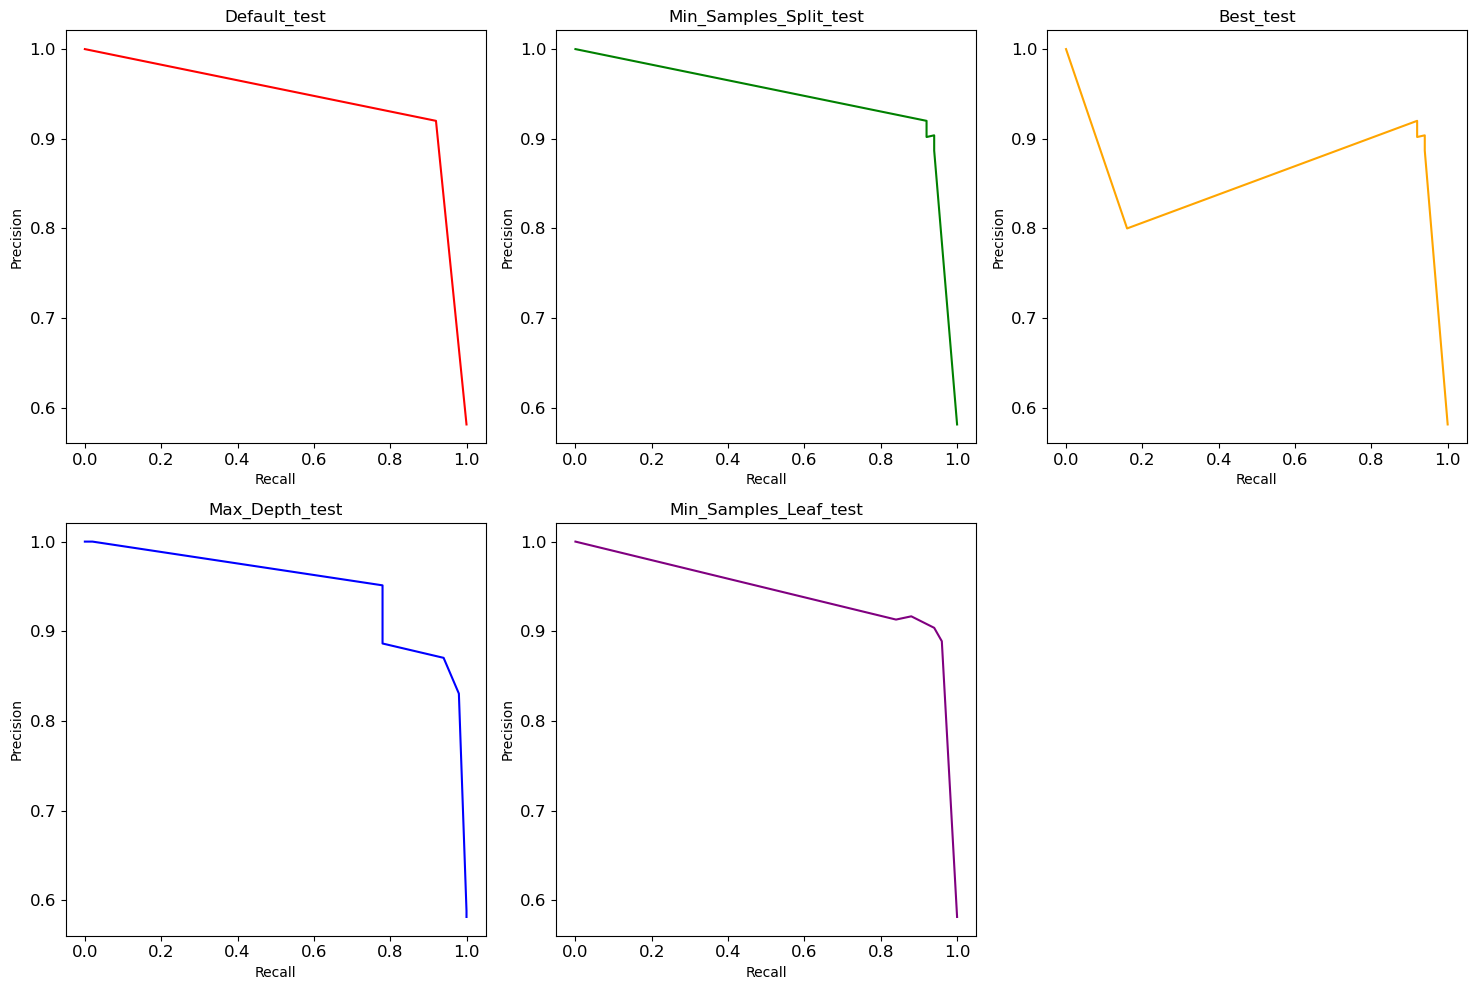

In [25]:
plot_precision_recall(cancer_train_X, cancer_train_y, labels_train)
plot_precision_recall(cancer_test_X, cancer_test_y, labels_test)

# 2 Concrete Slump Dataset

In [26]:
concrete_data = pd.read_csv('slump_test.data')
concrete_data.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [27]:
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   No                                  103 non-null    int64  
 1   Cement                              103 non-null    float64
 2   Slag                                103 non-null    float64
 3   Fly ash                             103 non-null    float64
 4   Water                               103 non-null    float64
 5   SP                                  103 non-null    float64
 6   Coarse Aggr.                        103 non-null    float64
 7   Fine Aggr.                          103 non-null    float64
 8   SLUMP(cm)                           103 non-null    float64
 9   FLOW(cm)                            103 non-null    float64
 10  Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 9.0 KB

By inspection of the dataset, the 'No' column is an instance label which is not part of the classification task. Therefore, we will remove this along with the other two output columns. 

In [28]:
# Dropping the index col
concrete_data.drop('No', axis=1, inplace=True)
# Dropping the other 2 targets
concrete_data.drop('SLUMP(cm)', axis=1, inplace=True)
concrete_data.drop('FLOW(cm)', axis=1, inplace=True)

## 2.1 Visualizing the Data

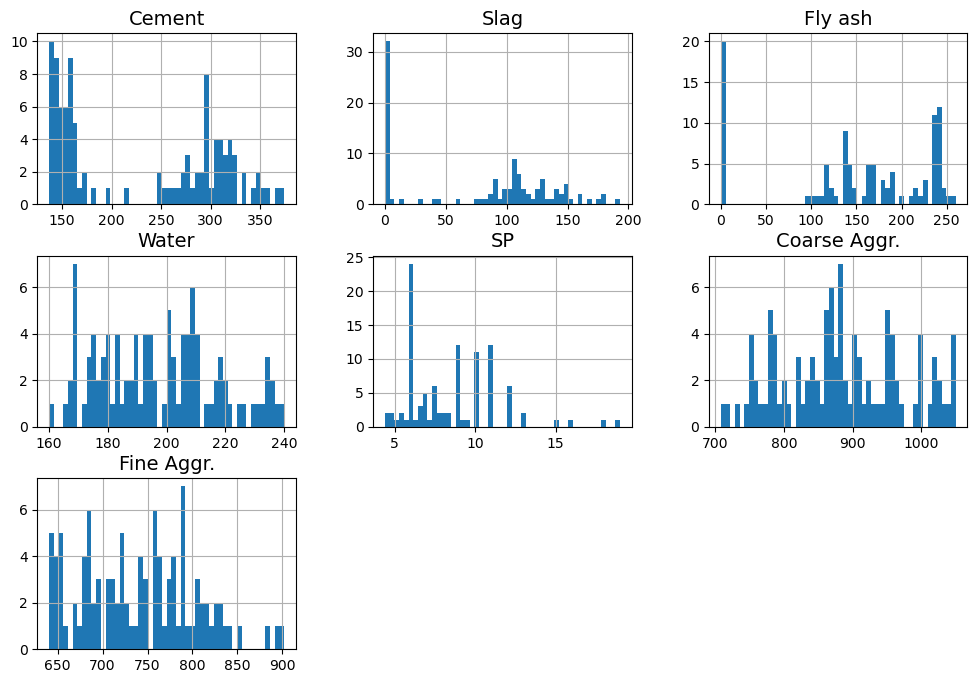

In [29]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

concrete_data.drop('Compressive Strength (28-day)(Mpa)', axis=1).hist(bins=50, figsize=(12, 8))
plt.show()

## 2.2 Splitting the Data

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Splitting the dataset into a training set (80%) and a testing set (20%) randomstate=123
con_train_X, con_test_X, con_train_y, con_test_y = train_test_split(concrete_data.drop('Compressive Strength (28-day)(Mpa)', axis=1), concrete_data['Compressive Strength (28-day)(Mpa)'], test_size=0.20, random_state=123)

# Creating a new instance of the standard scaler
scaler_func_1 = MinMaxScaler(feature_range=(0,1))

con_train_X = scaler_func.fit_transform(con_train_X)
con_test_X = scaler_func.transform(con_test_X)

#Transform back into a pd dataframe
feature_cols = ["Cement","Slag","Fly ash","Water","SP","Coarse Aggr.","Fine Aggr."]
con_train_X=pd.DataFrame(con_train_X, columns=feature_cols)
con_test_X=pd.DataFrame(con_test_X, columns=feature_cols)


## 2.3 Estimators with default parameters

In this section, a linear SVM regressor, linear regressor and a stochastic gradient descent regressor were trained using their default hyperparameters. A voting regressor based on the aforementioned three regressors was also trained using default parameters. 

In [31]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor

con_svr = SVR(kernel='linear')
con_lin = LinearRegression()
con_sgd = SGDRegressor()
con_voting = VotingRegressor([('Linear_SVR', con_svr), ('Linear-Reg', con_lin), ('SGD_Reg', con_sgd)])

con_lin.fit(con_train_X, con_train_y)
con_svr.fit(con_train_X, con_train_y)
con_sgd.fit(con_train_X, con_train_y)
con_voting.fit(con_train_X, con_train_y)

VotingRegressor(estimators=[('Linear_SVR', SVR(kernel='linear')),
                            ('Linear-Reg', LinearRegression()),
                            ('SGD_Reg', SGDRegressor())])

### 2.3.1 Results and plots

In [32]:
from sklearn.metrics import mean_squared_error

# def plot_con_predictions(regressors):
#     rmse = []
#     indexes = np.arange(0,21,1)

#     plt.plot(indexes, con_test_y, label="GroundTruth")

#     for reg in regressors:
#         y_pred = reg.predict(con_test_X)
#         rmse_val = np.sqrt(mean_squared_error(con_test_y, y_pred))
#         rmse.append(rmse_val)
#         plt.plot(indexes, y_pred, label=reg.__class__.__name__)
#         print("RMSE value for {} regressor is: {}".format(reg.__class__.__name__, rmse_val))

#     plt.legend(loc='best', fontsize=8)
#     plt.xlabel("Index", fontsize=15)
#     plt.ylabel("Value", fontsize=15)
#     plt.title("Predict Values", fontsize=15)
#     plt.show()
    
#     return rmse

In [33]:
from sklearn.metrics import r2_score

def plot_con_predictions(regressors):
    rmse = []
    
    # Draw dotted line at 45-degree angle
    x = np.linspace(15, 50, 100)
    plt.plot(x, x, '--', color='gray')

    for reg in regressors:
        y_pred = reg.predict(con_test_X)
        rmse_val = np.sqrt(mean_squared_error(con_test_y, y_pred))
        rmse.append(rmse_val)
        r2_score_val = r2_score(con_test_y, y_pred)
        plt.scatter(con_test_y, y_pred, label=reg.__class__.__name__)
        print("RMSE value for {} regressor is: {}".format(reg.__class__.__name__, rmse_val))
        print("R2 score for {} regressor is: {}".format(reg.__class__.__name__, r2_score_val))

    plt.legend(loc='best', fontsize=8)
    plt.xlabel("Index", fontsize=15)
    plt.ylabel("Value", fontsize=15)
    plt.title("Predict Values", fontsize=15)
    plt.show()

    return rmse

In [34]:
def plot_con_bars(rmse):
    labels = ['Linear_SVR', 'Linear-Reg', 'SGD_Reg', 'Voting_Reg']

    colors = ['b', 'g', 'r', 'y']

    fig, ax = plt.subplots()

    # create a bar chart with labels, rmse values, and colors
    ax.bar(labels, rmse, color=colors)

    # add the truncated rmse values on top of each bar
    for i, v in enumerate(rmse):
        ax.text(i, v + 0.1, str(round(v, 5)), ha='center', fontsize=10)

    # set the title and axis labels
    ax.set_title('RMSE Values')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')

    # display the plot
    plt.show()

A voting regressor combines the strengths of the models that comprise it. Through this, we expect the RMSE value of the voting regressor to be lower than the RMSE value of each of the specific regressors that make up the model. However, in this case we see that the RMSE of the voting regressor (3.12) is higher than the RMSE of the linear SVR regressor (2.91).

A possible explanation for this can be found by examining the predicted values for each regressor versus the ground truth values. For each regressor, the line which illustrates their predictions are so close to each other that they are virtually indistinguishable from one another. These lines all share the same deviation from the ground truth value.

This suggests that the three regressors are likely learning similar patterns in the data. This could happen if the features used by each of the regressors are highly correlated with each other, or if the data itself has a strong linear relationship with the target variable.

Therefore, it is likely that the voting regressor did significantly improve the prediction performance over any of the individual regressors. The individual regressors may have produced similar predictions that are biased in the same direction, and the voting regressor may simply average these ever so slightly different biased predictions without being able to correct them.

RMSE value for SVR regressor is: 2.9104631777060073
R2 score for SVR regressor is: 0.7904237972242639
RMSE value for LinearRegression regressor is: 3.293878415198133
R2 score for LinearRegression regressor is: 0.7315688711845898
RMSE value for SGDRegressor regressor is: 3.1738585239834927
R2 score for SGDRegressor regressor is: 0.7507742697990731
RMSE value for VotingRegressor regressor is: 3.1289661086701557
R2 score for VotingRegressor regressor is: 0.7577747195856855


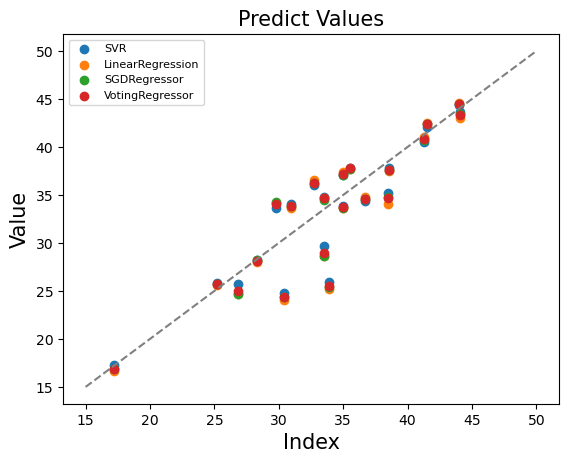

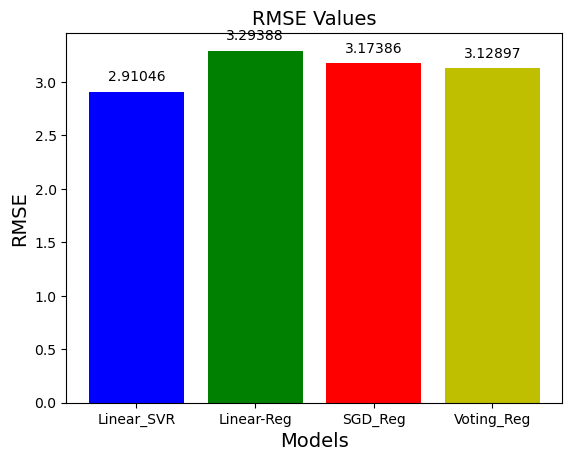

In [35]:
# GET the R2 VALUE FOR EACH REGRESSOR AND PRINT IT
regressors = [con_svr, con_lin, con_sgd, con_voting]

rmse = plot_con_predictions(regressors)
plot_con_bars(rmse)

## 2.4 Tuning Hyperparameters

### 2.4.1 Linear SVR Regressor

In [36]:
svr = SVR(kernel='linear')

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# Fit the grid search object to the training data
grid_search.fit(con_train_X, con_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'C': 10, 'epsilon': 1}
Best cross-validation score: -2.5299916017290927


### 2.4.2 SGD Regressor

In [37]:
sgd = SGDRegressor()

# Define the hyperparameters and their possible values for grid search
param_grid = {
    'alpha': [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
}

# Create a grid search object with 3-fold cross-validation
grid_search = GridSearchCV(sgd, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# Fit the grid search object to the training data
grid_search.fit(con_train_X, con_train_y)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 0.001}
Best cross-validation score: -2.6573370390827336


### 2.4.3 Estimators with tuned parameters

It can be seen from the plot of ground truth values versus the predicted values that the predicted values of the tuned regressor deviated further from the ground truth values than the previous regressor. This is corroborated by the increase in RMSE values across each regressor. 

A possible answer for this phenomenon is that the tuning hyperparameters resulted in overfitting. This can happen when the model is too complex for the given dataset, and the hyperparameters are tuned to fit the training set too closely, leading to poor  generalization on the test set.

Another possibility is that the tuning process changed the behavior of the individual regressors and caused them to become less complementary in the voting ensemble. This can happen if the tuning process led to the individual regressors becoming more similar in their predictions, which would reduce the diversity of the ensemble and make it less effective. This can be reflected in the following ways:

- Increased bias: when the base estimators are tuned to be too similar, they tend to make similar errors which could amplify biases in the model. 
- Variance: The goal of a voting regressor is to use average of multible base regressors to reduce the variance. However, by making our model less diverse, we lose the benefit of taking the average and are not actually lowering the variance in the model. 

In [38]:
con_svr_tuned = SVR(kernel='linear', C=10, epsilon=1)
con_lin_tuned = LinearRegression()
con_sgd_tuned = SGDRegressor(alpha=0.0000001)
con_voting_tuned = VotingRegressor([('Linear_SVR', con_svr_tuned), ('Linear-Reg', con_lin_tuned), ('SGD_Reg', con_sgd_tuned)])

con_lin_tuned.fit(con_train_X, con_train_y)
con_svr_tuned.fit(con_train_X, con_train_y)
con_sgd_tuned.fit(con_train_X, con_train_y)
con_voting_tuned.fit(con_train_X, con_train_y)

VotingRegressor(estimators=[('Linear_SVR',
                             SVR(C=10, epsilon=1, kernel='linear')),
                            ('Linear-Reg', LinearRegression()),
                            ('SGD_Reg', SGDRegressor(alpha=1e-07))])

RMSE value for SVR regressor is: 3.5007749804302253
R2 score for SVR regressor is: 0.6967881696452292
RMSE value for LinearRegression regressor is: 3.293878415198133
R2 score for LinearRegression regressor is: 0.7315688711845898
RMSE value for SGDRegressor regressor is: 3.18888404764548
R2 score for SGDRegressor regressor is: 0.7484089399168573
RMSE value for VotingRegressor regressor is: 3.319380938514212
R2 score for VotingRegressor regressor is: 0.7273961779541713


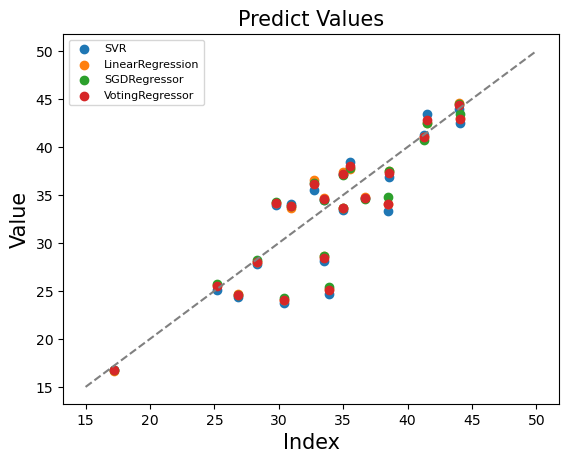

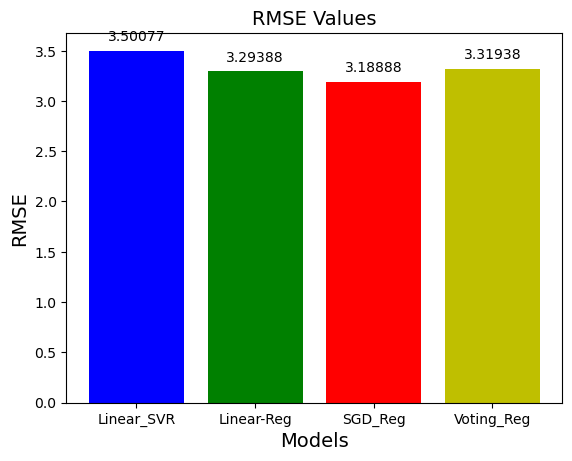

In [39]:
regressors = [con_svr_tuned, con_lin_tuned, con_sgd_tuned, con_voting_tuned]

rmse = plot_con_predictions(regressors)
plot_con_bars(rmse)

# 3 Abalone Dataset

In [40]:
from sklearn.preprocessing import OrdinalEncoder

# Read in data
ab_data = pd.read_csv('abalone.data')
# Col names from https://archive.ics.uci.edu/ml/datasets/Abalone
col_names = ["Sex","Length","Diameter continuous","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"]
ab_data.columns=col_names

# Creating an instance of the ordinal encoder 
enc = OrdinalEncoder(categories=[['M','F','I']])
ab_data['Sex'] = enc.fit_transform(ab_data['Sex'].values.reshape(-1,1))

ab_data.head()

,Sex,Length,Diameter continuous,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,1.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,0.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,2.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,2.0,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


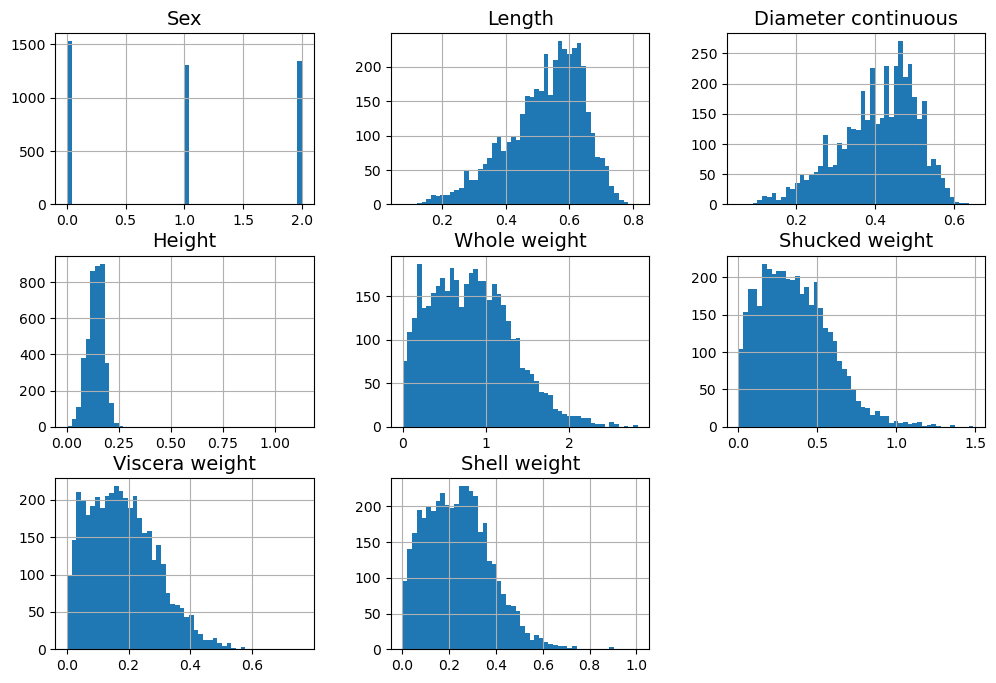

In [41]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

ab_data.drop('Rings', axis=1).hist(bins=50, figsize=(12, 8))
plt.show()

In [42]:
# Splitting the dataset into a training set (85%) and a testing set (15%) randomstate=123
ab_train_X, ab_test_X, ab_train_y, ab_test_y = train_test_split(ab_data.drop('Rings', axis=1), ab_data['Rings'], test_size=0.15, random_state=123)

# Creating a new instance of the standard scaler
scaler_func_2 = MinMaxScaler(feature_range=(0,1))

ab_train_X = scaler_func.fit_transform(ab_train_X)
ab_test_X = scaler_func.transform(ab_test_X)

#Transform back into a pd dataframe
feature_cols = ["Sex","Length","Diameter continuous","Height","Whole weight","Shucked weight","Viscera weight","Shell weight"]
ab_train_X=pd.DataFrame(ab_train_X, columns=feature_cols)
ab_test_X=pd.DataFrame(ab_test_X, columns=feature_cols)

## 3.1 Tuning Max_Depth

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def tune_max_depth():
    # Set the range of max_depth values to test
    max_depths = range(1, 21)

    # Initialize empty lists to store the errors
    train_errors = []
    cv_errors = []
    test_errors = []

    # Loop through each value of max_depth and fit a decision tree regression model
    for max_depth in max_depths:
        dt = DecisionTreeRegressor(max_depth=max_depth)

        # Evaluate the model using cross-validation
        cv_scores = cross_val_score(dt, ab_train_X, ab_train_y, cv=3, scoring='neg_mean_squared_error')
        cv_error = -1 * cv_scores.mean()
        cv_errors.append(cv_error)

        # Fit the model on the training data and evaluate its performance on the training set
        dt.fit(ab_train_X, ab_train_y)
        train_error = ((dt.predict(ab_train_X) - ab_train_y) ** 2).mean()
        train_errors.append(train_error)

        # Evaluate the model on the test data
        test_error = ((dt.predict(ab_test_X) - ab_test_y) ** 2).mean()
        test_errors.append(test_error)

    min_cv_error = min(cv_errors)
    min_cv_error_index = cv_errors.index(min_cv_error)
    best_max_depth_cv = max_depths[min_cv_error_index]

    min_test_error = min(test_errors)
    min_test_error_index = test_errors.index(min_test_error)
    best_max_depth_test = max_depths[min_test_error_index]

    print('max_depth that minimizes cv error:', best_max_depth_cv)
    print('max_depth that minimizes test error:', best_max_depth_test)

    # Plot the errors as a function of max_depth
    plt.plot(max_depths, train_errors, label='Training error')
    plt.plot(max_depths, cv_errors, label='Cross-validation error')
    plt.plot(max_depths, test_errors, label='Test error')
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

The value of max_depth chosen based on the plot of training errors, cross-validation errors and test errors as a function max depth is 5.

We want to minimize the cross-validation error rather than the test error because the primary purpose of cross-validation is to estimate the model's performance on new, unseen data. Cross-validation provides an estimate of the generalization error of the model, which is the error that the model is expected to make on new data.

Minimizng the error on the test set could also result in overfitting when the model is used to predict new unseen data in the future.

max_depth that minimizes cv error: 5
max_depth that minimizes test error: 4


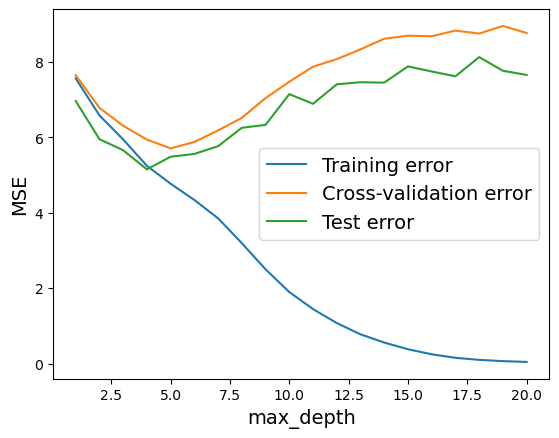

In [44]:
tune_max_depth()

## 3.2 Tuning Min_Samples_Leaf

In [45]:
def tune_min_samples_leaf():

    # Set the range of min_leaf values to test
    min_leafs = range(1, 150)

    # Initialize empty lists to store the errors
    train_errors = []
    cv_errors = []
    test_errors = []

    # Loop through each value of min_leaf and fit a decision tree regression model
    for min_leaf in min_leafs:
        dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=min_leaf)

        # Evaluate the model using cross-validation
        cv_scores = cross_val_score(dt, ab_train_X, ab_train_y, cv=3, scoring='neg_mean_squared_error')
        cv_error = -1 * cv_scores.mean()
        cv_errors.append(cv_error)

        # Fit the model on the training data and evaluate its performance on the training set
        dt.fit(ab_train_X, ab_train_y)
        train_error = ((dt.predict(ab_train_X) - ab_train_y) ** 2).mean()
        train_errors.append(train_error)

        # Evaluate the model on the test data
        test_error = ((dt.predict(ab_test_X) - ab_test_y) ** 2).mean()
        test_errors.append(test_error)

    min_cv_error = min(cv_errors)
    min_cv_error_index = cv_errors.index(min_cv_error)
    best_max_depth_cv = min_leafs[min_cv_error_index]

    min_test_error = min(test_errors)
    min_test_error_index = test_errors.index(min_test_error)
    best_max_depth_test = min_leafs[min_test_error_index]

    print('max_depth that minimizes cv error:', best_max_depth_cv)
    print('max_depth that minimizes test error:', best_max_depth_test)

    # Plot the errors as a function of min_leaf
    plt.plot(min_leafs, train_errors, label='Training error')
    plt.plot(min_leafs, cv_errors, label='Cross-validation error')
    plt.plot(min_leafs, test_errors, label='Test error')
    plt.xlabel('min_leaf')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

The value of max_depth chosen based on the plot of training errors, cross-validation errors and test errors as a function max depth is 20.

We want to minimize the cross-validation error rather than the test error because the primary purpose of cross-validation is to estimate the model's performance on new, unseen data. Cross-validation provides an estimate of the generalization error of the model, which is the error that the model is expected to make on new data.

Minimizng the error on the test set could also result in overfitting when the model is used to predict new unseen data in the future.

max_depth that minimizes cv error: 54
max_depth that minimizes test error: 59


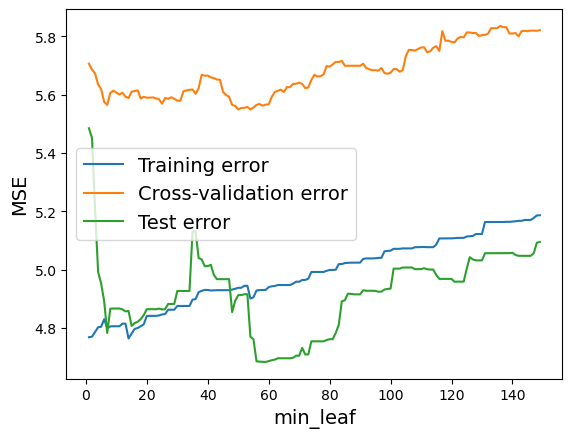

In [46]:
tune_min_samples_leaf()

## 3.3 Random Forest with 500 Estimators 

The following cell takes a very long time to run and has been commented out. The 4 hyperparameters have been chosen for this grid search using 3 fold cross validation and the best parameters have been found:

- booststrap: True
- max_depth: 16
- max_features: log2
- min_samples_leaf: 4

In [47]:
from sklearn.ensemble import RandomForestRegressor

# forest = RandomForestRegressor()

# # Define the hyperparameters and their possible values for grid search
# param_grid = {
#     'max_depth': range(1, 21),
#     'min_samples_leaf': range(1, 21),
#     'max_features': [1.0, 'sqrt', 'log2'],
#     'bootstrap': [True, False]  
# }

# # Create a grid search object with 3-fold cross-validation
# grid_search = GridSearchCV(forest, param_grid, cv=3, scoring='neg_root_mean_squared_error')
# # Fit the grid search object to the training data
# grid_search.fit(ab_train_X, ab_train_y)

# # Print the best hyperparameters
# print("Best hyperparameters:", grid_search.best_params_)

# # Print the best cross-validation score
# print("Best cross-validation score:", grid_search.best_score_)

In [48]:
# Create a random forest regressor with best hyperparameters
forest = RandomForestRegressor(max_depth=16, bootstrap=True, max_features='log2', min_samples_leaf=4)
# fit regressor to training data
forest.fit(ab_train_X, ab_train_y)
# predict on test set
y_pred = forest.predict(ab_test_X)
# round to closest int
np.rint(y_pred)
# get rmse value
forest_rmse = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', forest_rmse)

The RMSE on the test set is: 2.01183246818694


In [49]:
# Create a random forest regressor with best hyperparameters
forest = RandomForestRegressor(max_depth=5, bootstrap=True, max_features='log2', min_samples_leaf=54)
# fit regressor to training data
forest.fit(ab_train_X, ab_train_y)
# predict on test set
y_pred = forest.predict(ab_test_X)
# round to closest int
np.rint(y_pred)
# get rmse value
forest_rmse = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', forest_rmse)

The RMSE on the test set is: 2.145543802324163


## 3.4 Feature Selection

- Use select from model
- Use get support to obtain feature mask
    - See that the sex col is false i.e. it is under the 0.05 importance threshold
- Drop that col
- RMSE goes up?


***PLOT ERROR vs actual point maybe?***

In [50]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(forest, prefit=True, threshold=0.05)
print("The feature mask is:", selector.get_support())

ab_train_X_1 = ab_train_X.drop('Sex', axis=1)
ab_test_X_1 = ab_test_X.drop('Sex', axis=1)

The feature mask is: [False  True  True  True  True  True  True  True]


In [51]:
# Create a random forest regressor with best hyperparameters
forest_1 = RandomForestRegressor(max_depth=16, bootstrap=True, max_features='log2', min_samples_leaf=4)
# fit regressor to training data
forest_1.fit(ab_train_X_1, ab_train_y)
# predict on test set
y_pred = forest_1.predict(ab_test_X_1)
# round to closest int
np.rint(y_pred)
# get rmse value
forest_rmse_reduced = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', forest_rmse)

The RMSE on the test set is: 2.145543802324163


## 3.5 Bagging Regressor

In [52]:
from sklearn.ensemble import BaggingRegressor
#experiment with hyperparameters from task sheet
bag = BaggingRegressor(SVR(kernel='rbf',gamma='auto',C=20),n_estimators=500,n_jobs=-1)

bag.fit(ab_train_X, ab_train_y)

# predict on the test set
y_pred = bag.predict(ab_test_X)
np.rint(y_pred)

bag_rmse = np.sqrt(mean_squared_error(ab_test_y, y_pred))
print('The RMSE on the test set is:', bag_rmse)

The RMSE on the test set is: 2.042311374781628


In [53]:
comparison = [forest_rmse, bag_rmse]

def compare_forest_bagging(rmse):
    labels = ['Random Forest', 'Bagging Regressor']

    colors = ['b', 'g']

    fig, ax = plt.subplots(figsize=(8,6))

    # create a bar chart with labels, rmse values, and colors
    ax.bar(labels, rmse, color=colors)

    # add the truncated rmse values on top of each bar
    for i, v in enumerate(rmse):
        ax.text(i, v + 0.1, str(round(v, 5)), ha='center', fontsize=10)

    # set the title and axis labels
    ax.set_title('RMSE Values')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')

    # display the plot
    plt.show()

The bagging regressor has a lower RMSE than the random forest regressor. 

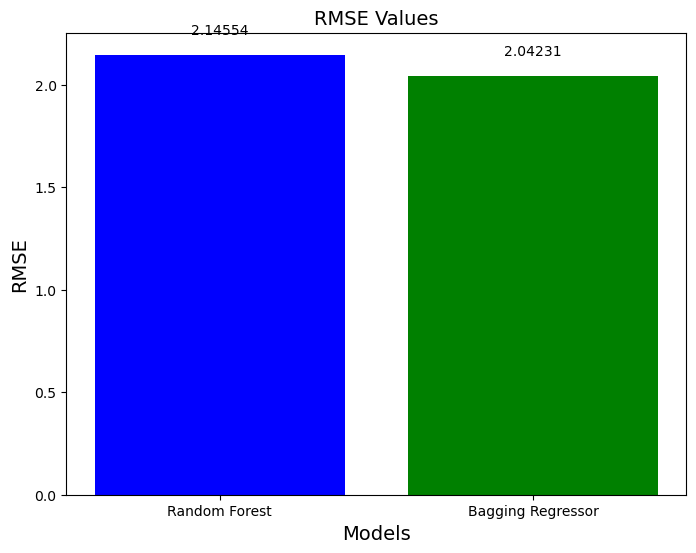

In [54]:
compare_forest_bagging(comparison)